In [1]:
#basic package
import json
import tqdm
import os
import numpy
import glob
import pandas as pd
import sys
import shutil
from PIL import Image
import pickle
import cv2
import urllib.request
import random 

#plot (for image verification)
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
path_data = os.path.join(ROOT_DIR,'datasets')

In [3]:
PACKAGE_PARENT = '../../..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from UTILS.utils import split_test_train_within_cat

/home/camille/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# the idea is to produce a dataframe with the following images information: 
#'saved_img_id','id','datetaken','latitude','longitude','photographer','license','url','img_path','species',
#'species_word', 'species_word_source', 'datasource'
li_info = ['saved_img_id','id','datetaken','latitude','longitude','ind_unit','license','url','img_path',
           'species','species_word', 'datasource']

# Download data

## flickr

In [5]:
#species word with only one letter are equal actually to the species itself (due to soe error I made initially but
#which is now corrected)
#TODO: replace those

In [6]:
#save metadata info (might not be of same size of number of collected images)
df_flickr = pd.read_csv(os.path.join(path_data,'flickr','flickr_image_info.csv'), sep=';', header=0, index_col=False)
print(df_flickr.shape)
df_flickr.head(3)

(57828, 33)


,id,species_word,accuracy,context,datetaken,datetakengranularity,datetakenunknown,description,farm,geo_is_contact,...,secret,server,species,tags,title,url_c,width_c,woeid,saved_img_id,img_path
0,6796830748,"['l', 'Pseudoelaps atropolios', 'Aspidomorphus...",0.0,0.0,2012-02-29 19:14:05,0.0,0.0,"{'_content': 'Lamington National Park, Qld'}",8.0,NaN,...,3b0faf2da2,7204.0,Cacophis squamulosus,NaN,Cacophis squamulosus (Golden-crowned Snake),https://farm8.staticflickr.com/7204/6796830748...,800.0,NaN,flickr_Cacophis squamulosus_6796830748.png,/home/camille/vm_exchange/Lab/snakes/datasets/...
1,6797027978,['California kingsnake'],0.0,0.0,2011-04-22 14:11:35,0.0,0.0,{'_content': 'Santa Clara County 4/22/2012'},8.0,NaN,...,b5d546df2e,7203.0,Lampropeltis californiae,NaN,California Kingsnake,https://farm8.staticflickr.com/7203/6797027978...,800.0,NaN,flickr_Lampropeltis californiae_6797027978.png,/home/camille/vm_exchange/Lab/snakes/datasets/...
2,6799008978,['Emerald tree boa'],0.0,0.0,2012-03-01 16:24:59,0.0,1.0,{'_content': 'emerald tree boa wpz'},8.0,NaN,...,c93e0025bd,7181.0,Corallus caninus,park tree woodland zoo snake boa emerald seatl...,emerald tree boa wpz 100_0301R3,https://farm8.staticflickr.com/7181/6799008978...,800.0,NaN,flickr_Corallus caninus_6799008978.png,/home/camille/vm_exchange/Lab/snakes/datasets/...


### remove potentially bad images

In [18]:
#TODO: with tags: place, landscape eggs etc
df_flickr['has_egg'] = df_flickr['description'].map(lambda x: 'eggs' in x)
df_flickr['tags'] = df_flickr['tags'].fillna('')
df_flickr['has_egg_tag'] = df_flickr['tags'].map(lambda x: 'eggs' in x)

In [24]:
df_flickr[df_flickr['has_egg_tag']==True]

,id,species_word,accuracy,context,datetaken,datetakengranularity,datetakenunknown,description,farm,geo_is_contact,...,species,tags,title,url_c,width_c,woeid,saved_img_id,img_path,has_egg,has_egg_tag
752,7023172539,['Checkered keelback'],0.0,0.0,2007-01-01 12:07:13,0.0,0.0,{'_content': 'The chequered keelback that laid...,8.0,NaN,...,Xenochrophis piscator,snake checkered chequered keelback sakeeggs,Checkered,https://farm8.staticflickr.com/7045/7023172539...,800.0,NaN,flickr_Xenochrophis piscator_7023172539.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,True,True
1769,7317849518,['Woma python'],0.0,0.0,2012-05-28 18:07:50,0.0,0.0,"{'_content': '29-May-2012, 13 eggs were laid b...",8.0,NaN,...,Aspidites ramsayi,summer nathan snake breeding eggs python capti...,Aspidites ramsayi,https://farm8.staticflickr.com/7075/7317849518...,800.0,NaN,flickr_Aspidites ramsayi_7317849518.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,True,True
1770,7317849760,"['Aspidites ramsayi', 'פיתון וומה', 'y', 'Kraj...",0.0,0.0,2012-05-28 18:07:27,0.0,0.0,"{'_content': '29-May-2012, 13 eggs were laid b...",8.0,NaN,...,Aspidites ramsayi,summer nathan snake breeding eggs python capti...,Aspidites ramsayi,https://farm8.staticflickr.com/7078/7317849760...,800.0,NaN,flickr_Aspidites ramsayi_7317849760.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,True,True
3577,8024849044,"['Aspidites ramsayi', 'פיתון וומה', 'y', 'Kraj...",0.0,0.0,2012-09-25 17:44:28,0.0,0.0,"{'_content': 'Born late July, 2012 on day 50 o...",9.0,NaN,...,Aspidites ramsayi,summer nathan snake breeding eggs python capti...,Aspidites ramsayi,https://farm9.staticflickr.com/8033/8024849044...,800.0,NaN,flickr_Aspidites ramsayi_8024849044.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,False,True
3578,8024849132,"['Aspidites ramsayi', 'פיתון וומה', 'y', 'Kraj...",0.0,0.0,2012-09-25 17:38:44,0.0,0.0,"{'_content': 'Born late July, 2012 on day 50 o...",9.0,NaN,...,Aspidites ramsayi,summer nathan snake breeding eggs python capti...,Aspidites ramsayi,https://farm9.staticflickr.com/8455/8024849132...,800.0,NaN,flickr_Aspidites ramsayi_8024849132.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,False,True
3579,8024850523,"['Aspidites ramsayi', 'פיתון וומה', 'y', 'Kraj...",0.0,0.0,2012-09-25 17:44:49,0.0,0.0,"{'_content': 'Born late July, 2012 on day 50 o...",9.0,NaN,...,Aspidites ramsayi,summer nathan snake breeding eggs python capti...,Aspidites ramsayi,https://farm9.staticflickr.com/8181/8024850523...,800.0,NaN,flickr_Aspidites ramsayi_8024850523.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,False,True
3617,8028114097,"['Aspidites ramsayi', 'פיתון וומה', 'y', 'Kraj...",0.0,0.0,2012-09-25 17:28:40,0.0,0.0,"{'_content': 'Hatched late July of 2012, 50 or...",9.0,NaN,...,Aspidites ramsayi,summer nathan snake breeding eggs python capti...,Aspidites ramsayi,https://farm9.staticflickr.com/8036/8028114097...,800.0,NaN,flickr_Aspidites ramsayi_8028114097.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,False,True
6649,8704946191,['Woma python'],0.0,0.0,2013-04-30 17:19:37,0.0,0.0,"{'_content': ""I set-up this Havo-bator incubat...",9.0,NaN,...,Aspidites ramsayi,canon nathan electronics eggs pulse shepard vi...,Incubator Set-up,https://farm9.staticflickr.com/8131/8704946191...,800.0,NaN,flickr_Aspidites ramsayi_8704946191.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,True,True
11593,12141453254,"['Cannia australis', 'g', 'l', 'Мулга', 'Naja ...",0.0,0.0,2014-01-25 13:35:42,0.0,0.0,"{'_content': 'Hatchling Mulga Snakes, Pseudech...",6.0,NaN,...,Pseudechis australis,snake australianwildlife snakeeggs kingbrownsn...,Mulga Snake Pseudechis australis,https://farm6.staticflickr.com/5533/1214145325...,800.0,NaN,flickr_Pseudechis australis_12141453254.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,True,True
19125,15959618157,"['Holarchus signatus', 'Oligodon subcarinatus'...",0.0,0.0,2014-12-20 21:21:55,0.0,0.0,{'_content': 'This Barred Kukri Snake (Oligodo...,8

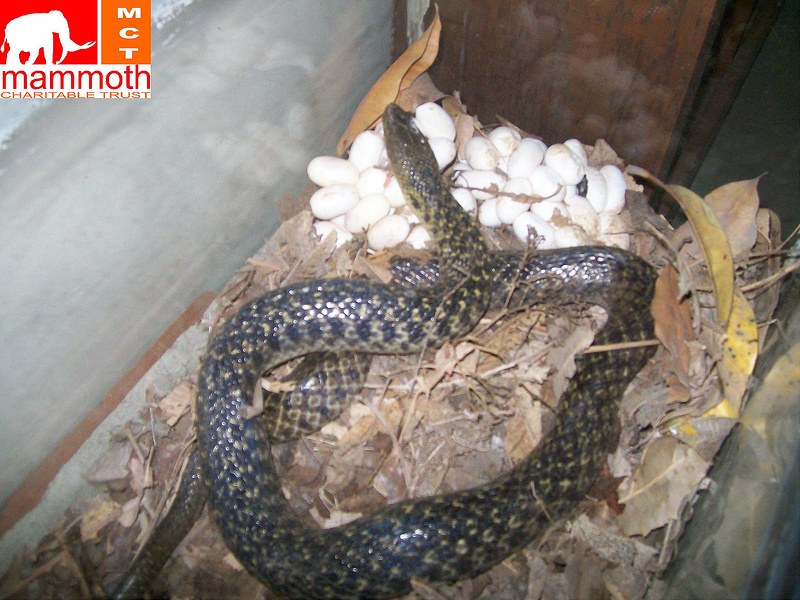

In [21]:
#wrong! this is a snake!
Image.open( urllib.request.urlopen(url))

In [9]:
#Boa constrictor vs Boa imperator should be removed form flickr after some discussion with Andrew
#hence, we will remove from the aggregated csv file, but keep it in the folder. 
print(df_flickr.shape)
df_flickr = df_flickr[~df_flickr['species'].isin(['Boa constrictor', 'Boa imperator'])]
print(df_flickr.shape)

(57828, 33)
(56840, 33)


df_flickr['nbr_species_word'] = df_flickr['species_word'].map(lambda x: len(eval(x)))
df_flickr[df_flickr['nbr_species_word']==1]
df_flickr['suspect'] = df_flickr.apply(lambda x: len(eval(x['species_word'])[0])==1 if x['nbr_species_word']==1 else False,
                                      axis=1)
url = df_flickr[df_flickr['suspect']].iloc[10]['url']
Image.open( urllib.request.urlopen(url))

### preprocessing

In [10]:
#add independant unit variable (not using the date as its better not to trust it... qulity seemed quite bad)
df_flickr['ind_unit'] = df_flickr.apply(lambda x: 'flickr_'+x['owner']+'_'+x['species'], axis=1)
df_flickr['datasource'] = 'flickr'
df_flickr = df_flickr.rename(columns={'url_c':'url'})
df_flickr = df_flickr.filter(li_info)

In [11]:
print(df_flickr.shape)
df_flickr.head(3)

(56840, 12)


,saved_img_id,id,datetaken,latitude,longitude,ind_unit,license,url,img_path,species,species_word,datasource
0,flickr_Cacophis squamulosus_6796830748.png,6796830748,2012-02-29 19:14:05,0.0,0.0,flickr_37993248@N06_Cacophis squamulosus,0.0,https://farm8.staticflickr.com/7204/6796830748...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Cacophis squamulosus,"['l', 'Pseudoelaps atropolios', 'Aspidomorphus...",flickr
1,flickr_Lampropeltis californiae_6797027978.png,6797027978,2011-04-22 14:11:35,0.0,0.0,flickr_77248512@N08_Lampropeltis californiae,0.0,https://farm8.staticflickr.com/7203/6797027978...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Lampropeltis californiae,['California kingsnake'],flickr
2,flickr_Corallus caninus_6799008978.png,6799008978,2012-03-01 16:24:59,0.0,0.0,flickr_28596361@N02_Corallus caninus,0.0,https://farm8.staticflickr.com/7181/6799008978...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Corallus caninus,['Emerald tree boa'],flickr


## herpmapper

In [12]:
#save metadata info (might not be of same size of number of collected images)
df_hm = pd.read_csv(os.path.join(path_data,'herpmapper','herpmapper_image_info.csv'),sep=';')
print(df_hm.shape)
#missing: latitude, longitude, license
df_hm.head(3)

(59475, 14)


,Date,Level 1,Level 2,Time,Country,species_word,ID,species,level_8,url,id,saved_img_id,img_path,datetaken
0,2006-11-08,Iowa,Johnson,13:42:00,United States of America,Storeria dekayi,HM 1,Storeria dekayi,0,https://www.herpmapper.org/content/voucher/0/1...,0-1,herpmapper_Storeria dekayi_0-1.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,2006-11-08 13:42:00
1,2006-11-04,Iowa,Linn,12:55:00,United States of America,Storeria dekayi,HM 5,Storeria dekayi,0,https://www.herpmapper.org/content/voucher/0/1...,0-13,herpmapper_Storeria dekayi_0-13.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,2006-11-04 12:55:00
2,2006-11-04,Iowa,Linn,12:55:00,United States of America,Storeria dekayi,HM 5,Storeria dekayi,1,https://www.herpmapper.org/content/voucher/0/...,0-14,herpmapper_Storeria dekayi_0-14.png,/home/camille/vm_exchange/Lab/snakes/datasets/...,2006-11-04 12:55:00


#### preprocessing

In [13]:
df_hm['ind_unit'] = df_hm.apply(lambda x: 'herpmapper_'+x['ID']+'_'+x['species'], axis=1)
df_hm['datasource'] = 'herpmapper'

In [14]:
#latitude, longitude not in herpmapper
df_hm = df_hm.filter(li_info)

In [15]:
df_hm.head(3)

,saved_img_id,id,datetaken,ind_unit,url,img_path,species,species_word,datasource
0,herpmapper_Storeria dekayi_0-1.png,0-1,2006-11-08 13:42:00,herpmapper_HM 1_Storeria dekayi,https://www.herpmapper.org/content/voucher/0/1...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Storeria dekayi,Storeria dekayi,herpmapper
1,herpmapper_Storeria dekayi_0-13.png,0-13,2006-11-04 12:55:00,herpmapper_HM 5_Storeria dekayi,https://www.herpmapper.org/content/voucher/0/1...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Storeria dekayi,Storeria dekayi,herpmapper
2,herpmapper_Storeria dekayi_0-14.png,0-14,2006-11-04 12:55:00,herpmapper_HM 5_Storeria dekayi,https://www.herpmapper.org/content/voucher/0/...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Storeria dekayi,Storeria dekayi,herpmapper


## inaturalist

In [16]:
#save metadata info (might not be of same size of number of collected images)
df_in = pd.read_csv(os.path.join(path_data,'inaturalist','inaturalist_image_info.csv'), sep=';')
print(df_in.shape)
df_in.head(3)

(113892, 39)


/home/camille/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,observed_on_string,observed_on,time_observed_at,time_zone,out_of_range,photographer,user_login,created_at,updated_at,...,positioning_device,species_guess,species_word,common_name,iconic_taxon_name,taxon_id,datetaken,species,saved_img_id,img_path
0,369,5/26/07,2007-05-26 00:00:00,NaN,Eastern Time (US & Canada),NaN,72,stellaoleary,2008-06-05 14:04:53 -0500,2014-10-19 22:06:17 -0500,...,NaN,black rat snake,Pantherophis alleghaniensis,Eastern Rat Snake,Reptilia,59644,2007-05-26 00:00:00,Pantherophis alleghaniensis,inaturalist_Pantherophis alleghaniensis_369.png,/home/camille/vm_exchange/Lab/snakes/datasets/...
1,1227,"May 20, 2006 15:49",2006-05-20 00:00:00,2006-05-20 22:49:00,Pacific Time (US & Canada),False,1,kueda,2009-01-13 02:29:54 -0600,2016-03-01 11:27:39 -0600,...,NaN,Western Terrestrial Garter Snake (Thamnophis e...,Thamnophis elegans,Western Terrestrial Garter Snake,Reptilia,28398,2006-05-20 22:49:00,Thamnophis elegans,inaturalist_Thamnophis elegans_1227.png,/home/camille/vm_exchange/Lab/snakes/datasets/...
2,1228,"May 13, 2006 19:36",2006-05-13 00:00:00,2006-05-14 02:36:00,Pacific Time (US & Canada),False,1,kueda,2009-01-13 02:29:54 -0600,2017-05-02 13:03:37 -0500,...,NaN,Western Terrestrial Garter Snake,Thamnophis elegans,Western Terrestrial Garter Snake,Reptilia,28398,2006-05-14 02:36:00,Thamnophis elegans,inaturalist_Thamnophis elegans_1228.png,/home/camille/vm_exchange/Lab/snakes/datasets/...


#### preprocessing

In [17]:
df_in['ind_unit'] = df_in.apply(lambda x: 'inaturalist_'+str(x['photographer'])+'_'+x['species'], axis=1)
df_in['datasource'] = 'inaturalist'
df_in = df_in.filter(li_info)

In [18]:
print(df_in.shape)
df_in.head(3)

(113892, 12)


,saved_img_id,id,datetaken,latitude,longitude,ind_unit,license,url,img_path,species,species_word,datasource
0,inaturalist_Pantherophis alleghaniensis_369.png,369,2007-05-26 00:00:00,41.316601,-72.558899,inaturalist_72_Pantherophis alleghaniensis,NaN,https://static.inaturalist.org/photos/401/medi...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Pantherophis alleghaniensis,Pantherophis alleghaniensis,inaturalist
1,inaturalist_Thamnophis elegans_1227.png,1227,2006-05-20 22:49:00,37.614403,-122.488457,inaturalist_1_Thamnophis elegans,CC0,https://static.inaturalist.org/photos/1349/med...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Thamnophis elegans,Thamnophis elegans,inaturalist
2,inaturalist_Thamnophis elegans_1228.png,1228,2006-05-14 02:36:00,37.664253,-122.055359,inaturalist_1_Thamnophis elegans,CC0,https://static.inaturalist.org/photos/1350/med...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Thamnophis elegans,Thamnophis elegans,inaturalist


### SNAPP - Andrew images

In [19]:
#save metadata info (might not be of same size of number of collected images)
df_s = pd.read_csv(os.path.join(path_data,'snapp_images','snapp-images.csv'))
print(df_s.shape)
df_s.head(3)

(2678, 12)


,filename,url,species,genus,family,country,locality,photographer,license,id-quality,captive,notes
0,0027.jpg,https://drive.google.com/a/aggiemail.usu.edu/f...,Agkistrodon contortrix,Agkistrodon,Viperidae,USA,NaN,NaN,NaN,certain,no,NaN
1,0028.jpg,https://drive.google.com/a/aggiemail.usu.edu/f...,Agkistrodon contortrix,Agkistrodon,Viperidae,USA,NaN,NaN,NaN,certain,no,NaN
2,0029.jpg,https://drive.google.com/a/aggiemail.usu.edu/f...,Agkistrodon contortrix,Agkistrodon,Viperidae,USA,NaN,NaN,NaN,certain,no,NaN


#### preprocessing

In [20]:
#Image.open(os.path.join(path_data, 'snapp_images', 'Agkistrodon', 'Agkistrodon contortrix', '0027.jpg'))

In [21]:
#add variable
#note that here the id use aso the ĵpg or png' format as it was done like this by andrew and that the endpoint change
#snapp missing: datetaken, latitude, longitude,
df_s['photographer'] = df_s['photographer'].fillna('')
df_s['ind_unit'] = df_s.apply(lambda x: 'snapp_'+x['photographer']+'_'+x['species'], axis=1)
df_s['datasource'] = 'snapp'
df_s = df_s.rename(columns={'filename':'id'})
df_s['saved_img_id'] = df_s['id'].copy()
df_s['species_word'] = df_s['species'].copy()
df_s['img_path'] = df_s.apply(lambda x: os.path.join(path_data,'snapp_images',x['genus'],x['species'], 
                                                     x['saved_img_id']), axis=1)
df_s = df_s.filter(li_info)

In [22]:
#remove the info without images
li_snapp_images = []
for genus in glob.glob(os.path.join(path_data,'snapp_images','*')):
    for species in glob.glob(os.path.join(genus,'*')):
        li_snapp_images.extend([x for x in glob.glob(os.path.join(species,'*'))])
len(li_snapp_images)
print('We have %d images collected from snapp'%len(li_snapp_images))

We have 2007 images collected from snapp


In [23]:
df_s = df_s[df_s['img_path'].isin(li_snapp_images)]
print(df_s.shape)
df_s.head(3)

(2007, 9)


,saved_img_id,id,ind_unit,license,url,img_path,species,species_word,datasource
0,0027.jpg,0027.jpg,snapp__Agkistrodon contortrix,NaN,https://drive.google.com/a/aggiemail.usu.edu/f...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Agkistrodon contortrix,Agkistrodon contortrix,snapp
1,0028.jpg,0028.jpg,snapp__Agkistrodon contortrix,NaN,https://drive.google.com/a/aggiemail.usu.edu/f...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Agkistrodon contortrix,Agkistrodon contortrix,snapp
2,0029.jpg,0029.jpg,snapp__Agkistrodon contortrix,NaN,https://drive.google.com/a/aggiemail.usu.edu/f...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Agkistrodon contortrix,Agkistrodon contortrix,snapp


# Aggregate

In [24]:
x1 = df_flickr.shape[0]
x2 = df_hm.shape[0]
x3 = df_in.shape[0]
x4 = df_s.shape[0]
print('We have in total: \n \n%d flickr images, \n%d herpmapper images, \n%d inaturalist images, \n%d snapp images'%(x1,x2,x3,x4))

We have in total: 
 
56840 flickr images, 
59475 herpmapper images, 
113892 inaturalist images, 
2007 snapp images


In [25]:
df = pd.concat([df_flickr, df_hm, df_in, df_s], ignore_index=True)
print(df.shape)
df.head(3)

(232214, 12)


,datasource,datetaken,id,img_path,ind_unit,latitude,license,longitude,saved_img_id,species,species_word,url
0,flickr,2012-02-29 19:14:05,6796830748,/home/camille/vm_exchange/Lab/snakes/datasets/...,flickr_37993248@N06_Cacophis squamulosus,0.0,0,0.0,flickr_Cacophis squamulosus_6796830748.png,Cacophis squamulosus,"['l', 'Pseudoelaps atropolios', 'Aspidomorphus...",https://farm8.staticflickr.com/7204/6796830748...
1,flickr,2011-04-22 14:11:35,6797027978,/home/camille/vm_exchange/Lab/snakes/datasets/...,flickr_77248512@N08_Lampropeltis californiae,0.0,0,0.0,flickr_Lampropeltis californiae_6797027978.png,Lampropeltis californiae,['California kingsnake'],https://farm8.staticflickr.com/7203/6797027978...
2,flickr,2012-03-01 16:24:59,6799008978,/home/camille/vm_exchange/Lab/snakes/datasets/...,flickr_28596361@N02_Corallus caninus,0.0,0,0.0,flickr_Corallus caninus_6799008978.png,Corallus caninus,['Emerald tree boa'],https://farm8.staticflickr.com/7181/6799008978...


# Add commun info

In [26]:
#TODO: species_word_source, genus

#### save 

In [27]:
df.to_csv(os.path.join(path_data,'df_all_datasource.csv'), index=False, sep=';')

# Register adequate df for crowdai challenge

In [28]:
df_crowdai = df.copy()

#### remove classes with less than 500 images

In [29]:
dico_species_nbrimage = dict(df['species'].value_counts())
df_crowdai['has_enough_images'] = df_crowdai['species'].map(lambda x: dico_species_nbrimage[x]>499)

In [30]:
print(df_crowdai.shape)
df_crowdai = df_crowdai[df_crowdai['has_enough_images']]
print(df_crowdai.shape)

(232214, 13)
(161217, 13)


#### remove classes with less than 20 ind_unit

In [31]:
df_ind_unit = df_crowdai.groupby('species')['ind_unit'].agg(lambda x: set(x)).reset_index()
df_ind_unit['nbr_ind_unit'] = df_ind_unit['ind_unit'].map(lambda x: len(x))
df_ind_unit.head(3)

,species,ind_unit,nbr_ind_unit
0,Agkistrodon contortrix,"{herpmapper_HM 186022_Agkistrodon contortrix, ...",2509
1,Agkistrodon piscivorus,"{herpmapper_HM 236918_Agkistrodon piscivorus, ...",1635
2,Ahaetulla prasina,"{flickr_42258227@N07_Ahaetulla prasina, flickr...",243


In [32]:
x = min(df_ind_unit['nbr_ind_unit'].tolist())
print('A species with at least 500 images has at least %d different independant unit'%x)

A species with at least 500 images has at least 71 different independant unit


In [33]:
dico_species_nbrindunit = dict(zip(df_ind_unit['species'].tolist(), df_ind_unit['nbr_ind_unit'].tolist()))
df_crowdai['has_enough_ind_unit'] = df_crowdai['species'].map(lambda x: dico_species_nbrindunit[x]>19)

In [34]:
print(df_crowdai.shape)
df_crowdai = df_crowdai[df_crowdai['has_enough_ind_unit']]
print(df_crowdai.shape)

(161217, 14)
(161217, 14)


#### keep only usefull info

In [35]:
li_crowdai = ['saved_img_id', 'id', 'ind_unit', 'license', 'url', 'img_path', 'species', 'datasource']
df_crowdai = df_crowdai.filter(li_crowdai)
df_crowdai.head(2)

,saved_img_id,id,ind_unit,license,url,img_path,species,datasource
1,flickr_Lampropeltis californiae_6797027978.png,6797027978,flickr_77248512@N08_Lampropeltis californiae,0,https://farm8.staticflickr.com/7203/6797027978...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Lampropeltis californiae,flickr
4,flickr_Natrix maura_6800854734.png,6800854734,flickr_74385542@N04_Natrix maura,0,https://farm8.staticflickr.com/7177/6800854734...,/home/camille/vm_exchange/Lab/snakes/datasets/...,Natrix maura,flickr


#### split into train and test set

In [36]:
df_crowdai_test, df_crowdai_train = split_test_train_within_cat(df=df_crowdai, p_test=0.2, 
                                                                category_to_split_within='species', 
                                                                id_to_split_with='ind_unit')

#### save

In [ ]:
df_crowdai.to_csv(os.path.join(path_data,'df_crowdai.csv'), index=False, sep=';')
df_crowdai_test.to_csv(os.path.join(path_data,'df_crowdai_test.csv'), index=False, sep=';')
df_crowdai_train.to_csv(os.path.join(path_data,'df_crowdai_train.csv'), index=False, sep=';')

#### small stat

In [40]:
len(set(df_crowdai_test['species'].tolist()))

85